# Using `photoeccentric` on a Real Kepler Light Curve

I'm fairly sure this code works (i.e. accurately recovers (e, w) for most light curves. A little spotty for w = 0 and e != 0, but I think this is to be expected.) Now I want to see if this works for a real Kepler light curve instead of noiseless transit models.

Notes:
   1. There's no way to actually know if this works if I don't know the planet's true eccentricity (and I probably won't). I am just checking for obvious problems here, but I won't be able to see if (e, w) is actually correct
   2. I am going to test `photoeccentric` more thoroughly on different transit models, thinking about the best way to do that

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
from astropy.io import fits

import astropy.stats as stats

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

import everest

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [148]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

In [149]:
lc_path = '/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/MAST_2021-02-10T1313/Kepler/kplr005868793_lc_Q000000111100000000/kplr005868793-2011177032512_llc.fits'

hdul = fits.open(lc_path)

In [150]:
data = hdul[1].data

In [151]:
time = data['TIME']

In [152]:
flux = data['SAP_FLUX']

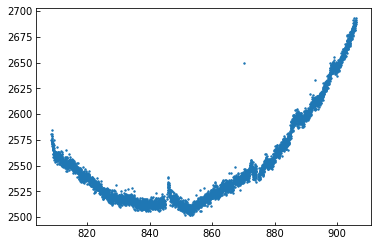

In [153]:
plt.scatter(time, flux, s=2)

A different planet

In [154]:
star = everest.Everest(201912552)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201912552.


INFO  [everest.user.plot()]: Plotting the light curve...


/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/everest/user.py:791: RuntimeWarning: invalid value encountered in less
  for i in np.where(flux < ylim[0])[0]:
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/everest/user.py:807: RuntimeWarning: invalid value encountered in greater
  for i in np.where(flux > ylim[1])[0]:


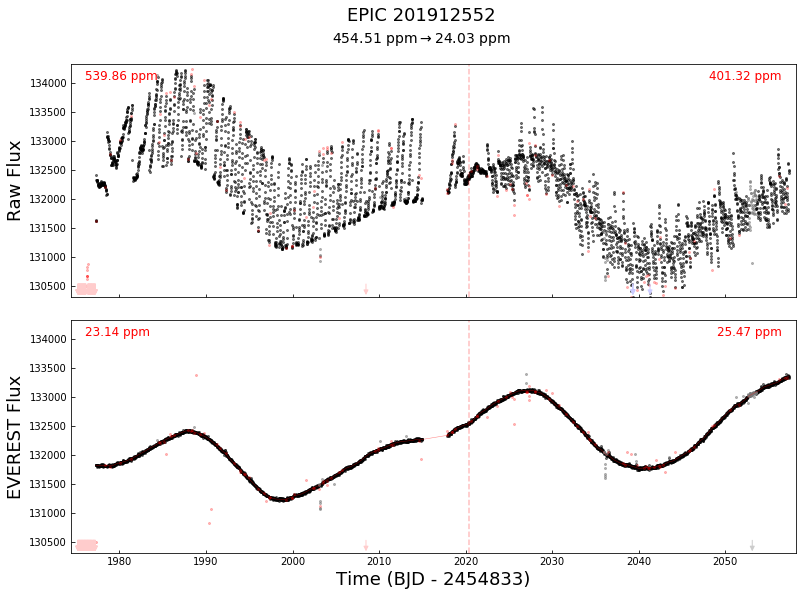

In [155]:
star.plot();

In [223]:
time = star.time
flux = star.flux

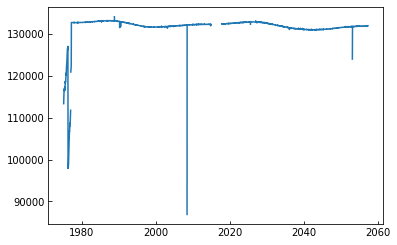

In [224]:
plt.plot(star.time, star.flux)

In [225]:
flux_sclip = stats.sigma_clip(flux, 2)

WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically clipped.


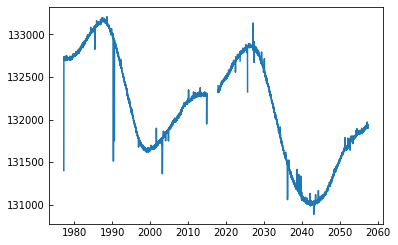

In [226]:
plt.plot(time, flux_sclip)

In [227]:
import scipy.signal as sig

In [228]:
median = sig.medfilt(flux_sclip, 151)

In [229]:
len(flux_sclip)

4022

In [230]:
len(time)

4022

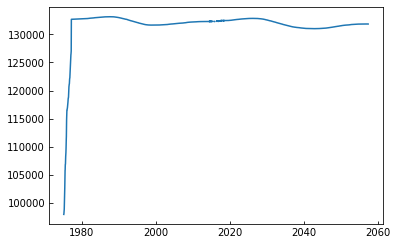

In [231]:
plt.plot(time, median)

In [232]:
nflux = flux_sclip-median

In [233]:
len(time)

4022

In [234]:
len(nflux)

4022

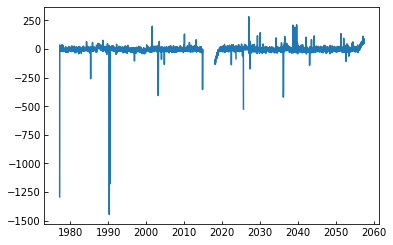

In [235]:
plt.plot(time, nflux)

## Fitting the transit

In [266]:
nflux = np.asarray(nflux)
time = np.asarray(time)

In [267]:
nanind = np.argwhere(np.isnan(nflux))

In [268]:
nflux = np.delete(nflux, nanind)
time = np.delete(time, nanind)

In [269]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")
per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]

In [270]:
# Inital guess: period, rprs, a/Rs, i, w
p0 = [32.939623, 0.05295, 83.83, 89.5785, -5.7]

# Priors (bounds) on some parameters; not using this right now
priors = ((-np.inf, -np.inf, 0.0, 0.0, -90.0), (np.inf, np.inf, 150.0, 90.0, 300.0))

popt, pcov = curve_fit(ph.planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=priors)

# Create a light curve with the fit parameters
fit = ph.planetlc_fitter(time, popt[0], popt[1], popt[2], popt[3], popt[4])


In [271]:
# Defining variables based on the fit parameters

p_f = popt[0]*86400 #days to seconds
perr_f = 0.001*86400 #days to seconds

rprs_f = popt[1]
rprserr_f = 0.001

a_f = popt[2]

i_f = popt[3] 

w_f = popt[4]

Fit params:
Period (days):  -3.2881595968170814 Rp/Rs:  -0.7673145039852765
a/Rs:  83.86816784962468
i (deg):  85.69655144322677
w (deg):  -5.7


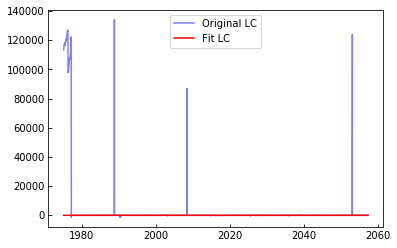

In [276]:
plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
#plt.xlim(1990, 1992)
plt.legend()

print('Fit params:')
print('Period (days): ', p_f/86400., 'Rp/Rs: ', rprs_f)
print('a/Rs: ', a_f)
print('i (deg): ', i_f)
print('w (deg): ', w_f)

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [277]:
T14 = ph.get_T14(p_f, rprs_f, a_f, i_f)
T14err = 0.0001*86400 #I'm assuming a T14 error here

T23 = ph.get_T23(p_f, rprs_f, a_f, i_f)
T23err = 0.0001*86400 #I'm assuming a T23 error here

/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:44: RuntimeWarning: invalid value encountered in sqrt
  T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180.0))) #Equation 14 in exoplanet textbook
/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/photoeccentric/photoeccentric.py:86: RuntimeWarning: invalid value encountered in sqrt
  T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180.))) #Equation 15 in exoplanet textbook


# Get $g$

In [278]:
gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f, perr_f, rprs_f, rprserr_f, T14, T14err, T23, T23err)

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

NameError: name 'rho_star' is not defined

Print $g$ and $\sigma_{g}$:

In [1032]:
g_mean

0.9649394155416416

In [1033]:
g_sigma

0.0582241000958546

The mean of $g$ is about 1.0, which means that $\rho_{circ}$ agrees with $\rho_{star}$ and the eccentricity of this transit must be zero, which is exactly what we input! We can take $g$ and $\sigma_{g}$ and use MCMC (`emcee`) to determine the surface of most likely $(e,w)$.

`photoeccentric` has the probability function for $(e,w)$ from $g$ built in to `ph.log_probability()`.

In [1034]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [1035]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 663.71it/s]


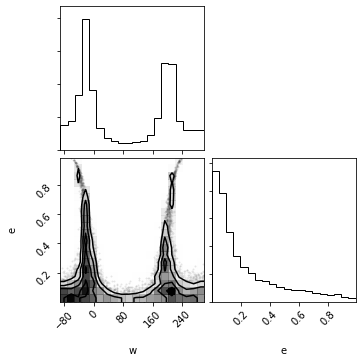

In [1036]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)

And here is the corner plot for the most likely values of $(e, w)$ that correspond to $g = 1$. The $e$ distribution peaks at 0!